In [1]:
import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns
import os.path
import matplotlib.pyplot as plt
import matplotlib.patches
import statsmodels.sandbox.stats.multicomp

In [2]:
%matplotlib inline
sns.set(font_scale=2)
sns.set_style("white")
from IPython.core.pylabtools import figsize

# Load linkage map

In [3]:
linkage_map = pd.read_csv(os.path.join('linkage_map', 'LEPmap', 'with_paralogs', 'final', 'PS_chum_map_2015.txt'), sep = '\t')
linkage_map = linkage_map[['contig', 'resolved_locus', 'stacks_CatID', 'stacks_SNP', 'LEP_LG', 'cM']]
linkage_map = linkage_map.rename(columns = {'resolved_locus':'locus', 'LEP_LG':'LG'})
print linkage_map.shape
linkage_map.head(3)

(12915, 6)


,contig,locus,stacks_CatID,stacks_SNP,LG,cM
0,c4311,4311,28282,28282_88,1,0
1,c4311,4311,28282,28282_91,1,0
2,c56875,56875,39970,39970_17,1,0


## Load pi

In [4]:
pi = pd.read_csv(os.path.join('results','batch_4','pop_analysis','within_pi.txt'), sep = '\t', header = None)
pi.columns = ['stacks_CatID', 'pop', 'pi_within']
pi.head()

,stacks_CatID,pop,pi_within
0,1,1,0.010896
1,1,2,0.010923
2,1,3,0.010897
3,1,4,0.010802
4,1,5,0.010785


In [5]:
pi = pi.groupby('stacks_CatID').mean()[['pi_within']].reset_index()
print pi.shape
pi.head()

(29131, 2)


,stacks_CatID,pi_within
0,1,0.010722
1,2,0.002251
2,4,0.000000
3,7,0.008768
4,9,0.005154


In [6]:
linkage_map = pd.merge(linkage_map, pi)
print linkage_map.shape
linkage_map.head()

(12915, 7)


,contig,locus,stacks_CatID,stacks_SNP,LG,cM,pi_within
0,c4311,4311,28282,28282_88,1,0,0.004380
1,c4311,4311,28282,28282_91,1,0,0.004380
2,c56875,56875,39970,39970_17,1,0,0.015672
3,c56875,56875,39970,39970_33,1,0,0.015672
4,c56875,56875,39970,39970_49,1,0,0.015672


# Load dxy

In [7]:
dxy = pd.read_csv(os.path.join('results','batch_4','pop_analysis','dxy.txt'), sep = '\t', header = None)
dxy.columns = ['stacks_CatID', 'pop1', 'pop2', 'dxy']
print dxy.shape
dxy.head()

(1310895, 4)


,stacks_CatID,pop1,pop2,dxy
0,1,5,9,0.010638
1,1,4,7,0.010638
2,1,1,3,0.010652
3,1,4,8,0.010618
4,1,5,6,0.010638


## Average value for each locus

In [8]:
dxy = dxy.groupby('stacks_CatID').mean()[['dxy']].reset_index()
print dxy.shape
dxy.head()

(29131, 2)


,stacks_CatID,dxy
0,1,0.010642
1,2,0.002187
2,4,0.000000
3,7,0.008766
4,9,0.005354


In [9]:
linkage_map = pd.merge(linkage_map, dxy)
print linkage_map.shape
linkage_map.head()

(12915, 8)


,contig,locus,stacks_CatID,stacks_SNP,LG,cM,pi_within,dxy
0,c4311,4311,28282,28282_88,1,0,0.004380,0.004441
1,c4311,4311,28282,28282_91,1,0,0.004380,0.004441
2,c56875,56875,39970,39970_17,1,0,0.015672,0.015804
3,c56875,56875,39970,39970_33,1,0,0.015672,0.015804
4,c56875,56875,39970,39970_49,1,0,0.015672,0.015804


why such a strong correlation?

 ### Get the Bayescan ID for each locus

In [10]:
# in the output from plink, column 2 is what we want
stacks_SNPs = pd.read_csv(os.path.join('results', 'batch_4', 'pop_analysis', 'bayescan', 'non_paralogs.map'),                        
            header = None, sep = '\t')
stacks_SNPs.columns =  ['ignore1', 'stacks_SNP', 'ignore2', 'ignore3']
stacks_SNPs['BSname'] = stacks_SNPs.index + 1
stacks_SNPs = stacks_SNPs[['stacks_SNP', 'BSname']]
stacks_SNPs.head(3)

,stacks_SNP,BSname
0,1013_6,1
1,2062_6,2
2,2574_6,3


In [11]:
lmap_BSnames = pd.merge(linkage_map, stacks_SNPs, how='outer')
lmap_BSnames.head()

,contig,locus,stacks_CatID,stacks_SNP,LG,cM,pi_within,dxy,BSname
0,c4311,4311,28282,28282_88,1,0,0.004380,0.004441,6440
1,c4311,4311,28282,28282_91,1,0,0.004380,0.004441,NaN
2,c56875,56875,39970,39970_17,1,0,0.015672,0.015804,NaN
3,c56875,56875,39970,39970_33,1,0,0.015672,0.015804,NaN
4,c56875,56875,39970,39970_49,1,0,0.015672,0.015804,NaN


In [12]:
len(lmap_BSnames)

19063

## Load Bayescan results

In [13]:
group_2_fst_file = os.path.join('results', 'batch_4', 'pop_analysis', 'bayescan', 'BS_group_2.baye_fst.txt')

def load_baye_fst(filename):
    baye_fst = pd.read_csv(filename, sep = " ", skiprows=1, header = None, skipinitialspace=True)
    baye_fst.columns = ['BSname','prob_bayescan','log10(PO)_bayescan','qval_bayescan','alpha_bayescan','Fst_bayescan', 'junk']
    baye_fst = baye_fst[['BSname','prob_bayescan','log10(PO)_bayescan','qval_bayescan','alpha_bayescan','Fst_bayescan']]
    baye_fst['mlog10(qval)_bayescan'] = -np.log10(baye_fst['qval_bayescan'])

    return(baye_fst)

BS_2 = load_baye_fst(group_2_fst_file)
BS_2.head()

,BSname,prob_bayescan,log10(PO)_bayescan,qval_bayescan,alpha_bayescan,Fst_bayescan,mlog10(qval)_bayescan
0,1,0.079708,-1.06242,0.858659,-0.034193,0.027787,0.066179
1,2,0.106910,-0.92187,0.725970,-0.077808,0.027054,0.139081
2,3,0.070507,-1.12000,0.883910,-0.022087,0.027977,0.053592
3,4,0.117810,-0.87437,0.643790,-0.099951,0.026676,0.191256
4,5,0.082108,-1.04840,0.850000,-0.036494,0.027769,0.070581


In [14]:
np.mean(BS_2['Fst_bayescan'])

0.03106205685942408

In [15]:
lmap_BS = pd.merge(lmap_BSnames, BS_2, how = 'outer')
lmap_BS.head()

,contig,locus,stacks_CatID,stacks_SNP,LG,cM,pi_within,dxy,BSname,prob_bayescan,log10(PO)_bayescan,qval_bayescan,alpha_bayescan,Fst_bayescan,mlog10(qval)_bayescan
0,c4311,4311,28282,28282_88,1,0,0.004380,0.004441,6440,0.074607,-1.0935,0.87532,-0.00809,0.028428,0.057833
1,c4311,4311,28282,28282_91,1,0,0.004380,0.004441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c56875,56875,39970,39970_17,1,0,0.015672,0.015804,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,c56875,56875,39970,39970_33,1,0,0.015672,0.015804,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c56875,56875,39970,39970_49,1,0,0.015672,0.015804,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Combine with Weir (1984) Fst

In [16]:
plink_fst = pd.read_csv(os.path.join('data', 'batch_4', 'pop_genotypes', 'non_paralogs.fst'), sep = "\t")
plink_fst= plink_fst.rename(columns = {'SNP':'stacks_SNP', 'FST':'Fst_weir'})
plink_fst = plink_fst[['stacks_SNP','Fst_weir']]
plink_fst.head()

,stacks_SNP,Fst_weir
0,1013_6,0.015589
1,2062_6,-0.002161
2,2574_6,0.017541
3,2741_6,-0.005708
4,4096_6,0.010227


In [17]:
np.mean(plink_fst['Fst_weir'])

0.02818570707827796

In [18]:
lmap_BS_FST = pd.merge(lmap_BS,plink_fst, how = 'outer') 

## Combine with LFMM statistics

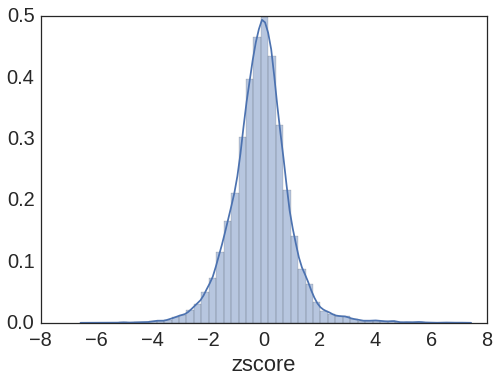

In [19]:
# get for duplicated loci
lfmm_dom = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/LFMM/lfmm_results.dom.txt', sep = '\t')
lfmm_dom.head()
sns.distplot(lfmm_dom['zscore'])
plt.show()

748

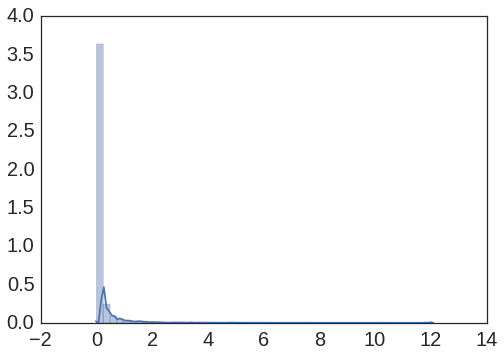

In [20]:
reject_null, fdr_pval, alphacSidak, alphacBonf = statsmodels.sandbox.stats.multicomp.multipletests(lfmm_dom['cpvals'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
lfmm_dom['reject_null_LFMM'] = reject_null
lfmm_dom['fdr_pval_LFMM'] = fdr_pval
lfmm_dom['mlog10(fdr_pval)_LFMM'] = -np.log10(lfmm_dom['fdr_pval_LFMM'] )
sns.distplot(lfmm_dom['mlog10(fdr_pval)_LFMM'].values)
lfmm_dom.head()
np.sum(lfmm_dom['reject_null_LFMM'])

## non-duplicated loci

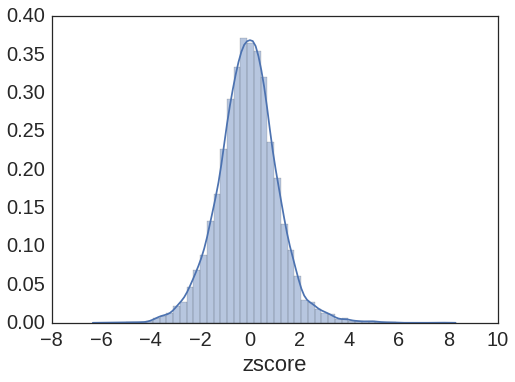

In [21]:
lfmm = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/LFMM/lfmm_results.txt', sep = '\t')
lfmm.head()
sns.distplot(lfmm['zscore'])
max(lfmm['zscore'])
plt.show()


Apply FDR correction

53

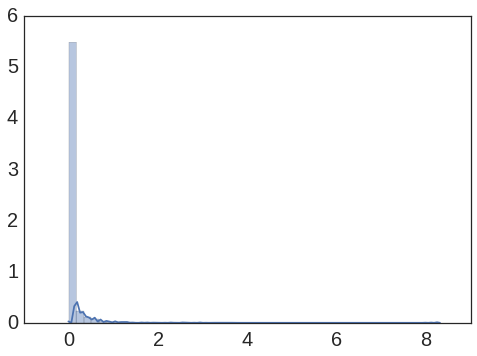

In [22]:
reject_null, fdr_pval, alphacSidak, alphacBonf = statsmodels.sandbox.stats.multicomp.multipletests(lfmm['cpvals'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
lfmm['reject_null_LFMM'] = reject_null
lfmm['fdr_pval_LFMM'] = fdr_pval
lfmm['mlog10(fdr_pval)_LFMM'] = -np.log10(lfmm['fdr_pval_LFMM'] )
sns.distplot(lfmm['mlog10(fdr_pval)_LFMM'].values)
lfmm.head()
np.sum(lfmm['reject_null_LFMM'])

In [23]:
lfmm['mlog10(fdr_pval)_LFMM'].mean() , lfmm_dom['mlog10(fdr_pval)_LFMM'].mean()

(0.06365689452512753, 0.1347580110143899)

In [24]:
lmap_BS_FST_LFMM = pd.merge(lmap_BS_FST, lfmm, how = 'outer', left_on='BSname', right_on='locnum')
lmap_BS_FST_LFMM.head()

,contig,locus,stacks_CatID,stacks_SNP,LG,cM,pi_within,dxy,BSname,prob_bayescan,...,alpha_bayescan,Fst_bayescan,mlog10(qval)_bayescan,Fst_weir,locnum,cpvals,zscore,reject_null_LFMM,fdr_pval_LFMM,mlog10(fdr_pval)_LFMM
0,c4311,4311,28282,28282_88,1,0,0.004380,0.004441,6440,0.074607,...,-0.00809,0.028428,0.057833,0.013742,6440,0.567927,-0.612083,False,0.995929,0.001772
1,c4311,4311,28282,28282_91,1,0,0.004380,0.004441,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c56875,56875,39970,39970_17,1,0,0.015672,0.015804,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,c56875,56875,39970,39970_33,1,0,0.015672,0.015804,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c56875,56875,39970,39970_49,1,0,0.015672,0.015804,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Select only loci on linkage map and scored for population genetic stats

In [25]:
lmap_BS_FST_LFMM = lmap_BS_FST_LFMM[lmap_BS_FST_LFMM['LG'].notnull()]
lmap_BS_FST_LFMM = lmap_BS_FST_LFMM[lmap_BS_FST_LFMM['BSname'].notnull()]
print lmap_BS_FST_LFMM.shape
lmap_BS_FST_LFMM.head()

(6251, 22)


,contig,locus,stacks_CatID,stacks_SNP,LG,cM,pi_within,dxy,BSname,prob_bayescan,...,alpha_bayescan,Fst_bayescan,mlog10(qval)_bayescan,Fst_weir,locnum,cpvals,zscore,reject_null_LFMM,fdr_pval_LFMM,mlog10(fdr_pval)_LFMM
0,c4311,4311,28282,28282_88,1,0,0.004380,0.004441,6440,0.074607,...,-0.008090,0.028428,0.057833,0.013742,6440,0.567927,-0.612083,False,0.995929,0.001772
6665,c56875,56875,39970,39970_60,1,0,0.015672,0.015804,6348,0.070007,...,-0.019498,0.027983,0.053233,0.016345,6348,0.245650,1.244280,False,0.937707,0.027933
6666,c54045,54045,37579,37579_17,1,0,0.019134,0.019840,6197,0.069907,...,0.004748,0.028735,0.053150,0.028103,6197,0.761393,-0.325439,False,0.997092,0.001265
6667,c2167,2167,10293,10293_9,1,0,0.007664,0.008148,6162,0.075208,...,-0.016256,0.028102,0.058608,0.014312,6162,0.502838,0.718105,False,0.995929,0.001772
6668,c69918,69918,50820,50820_7,1,0,0.003673,0.003734,6154,0.069207,...,-0.019918,0.027949,0.052753,0.015249,6154,0.371955,0.956875,False,0.977007,0.010102


In [26]:
print np.mean(plink_fst['Fst_weir'])
print np.mean(BS_2['Fst_bayescan'])



lmap_BS_FST_LFMM[['Fst_weir', 'Fst_bayescan', 'mlog10(fdr_pval)_LFMM']].mean()

0.0281857070783
0.0310620568594


Fst_weir                 0.027363
Fst_bayescan             0.030268
mlog10(fdr_pval)_LFMM    0.051308
dtype: float64

/home/ipseg/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


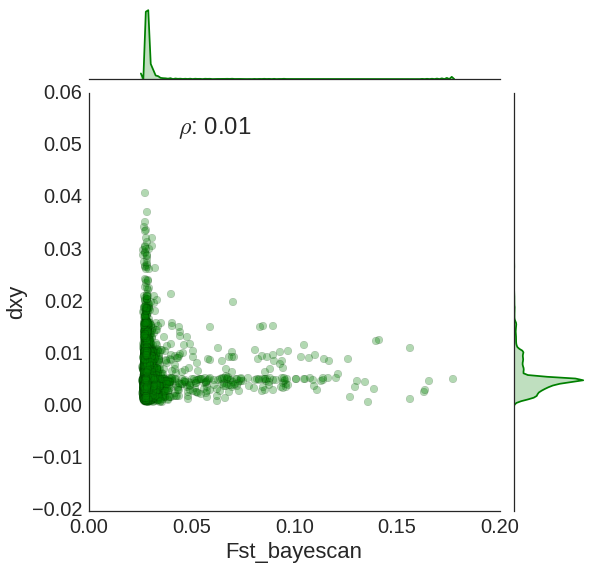

In [27]:
g = sns.JointGrid(x='Fst_bayescan', 
                y='dxy',
                data = lmap_BS_FST_LFMM,
                size = 8)
g = g.plot_joint(plt.scatter, color="g", s=60, edgecolor="black", alpha = .3)
g = g.plot_marginals(sns.kdeplot, color="g", shade=True)
rho = lambda a, b: scipy.stats.spearmanr(a, b)[0] 
g = g.annotate(rho, template="{stat}: {val:.2f}", stat=r'$\rho$', loc="upper left", fontsize=24)
g.set_axis_labels('Fst_bayescan','dxy')
plt.show()

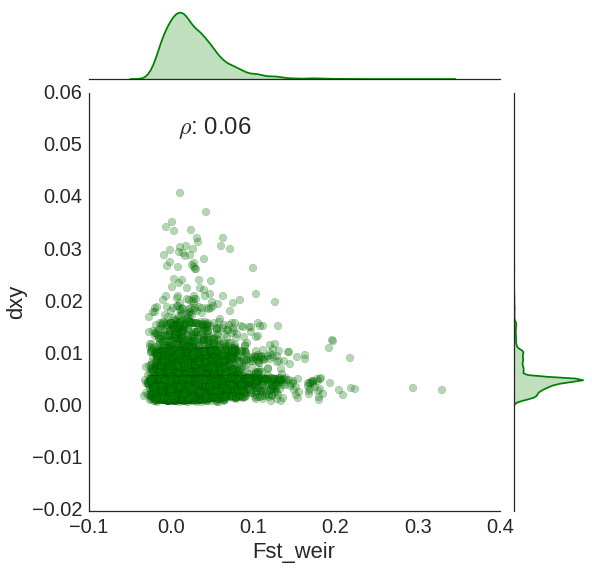

In [28]:
g = sns.JointGrid(x='Fst_weir', 
                y='dxy',
                data = lmap_BS_FST_LFMM,
                size = 8)
g = g.plot_joint(plt.scatter, color="g", s=60, edgecolor="black", alpha = .3)
g = g.plot_marginals(sns.kdeplot, color="g", shade=True)
rho = lambda a, b: scipy.stats.spearmanr(a, b)[0] 
g = g.annotate(rho, template="{stat}: {val:.2f}", stat=r'$\rho$', loc="upper left", fontsize=24)
g.set_axis_labels('Fst_weir','dxy')
plt.show()

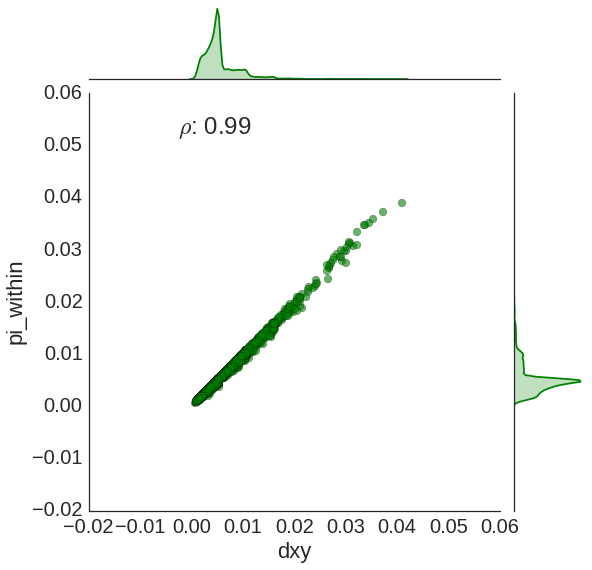

In [29]:
g = sns.JointGrid(x='dxy', 
                y='pi_within',
                data = lmap_BS_FST_LFMM,
                #xlim = (-.04),
                #ylim = (-.04),
                size = 8)
g = g.plot_joint(plt.scatter, color="g", s=60, edgecolor="black", alpha = .6)
g = g.plot_marginals(sns.kdeplot, color="g", shade=True)
rho = lambda a, b: scipy.stats.spearmanr(a, b)[0] 
g = g.annotate(rho, template="{stat}: {val:.2f}", stat=r'$\rho$', loc="upper left", fontsize=24)
plt.show()

## Add 20cM between linkage groups - easier to visualize

In [30]:
cumpos = pd.DataFrame(lmap_BS_FST_LFMM.groupby('LG')['cM'].max().cumsum())
cumpos.index = cumpos.index+1
cumpos.set_value(1, 'cM', 0)
cumpos = cumpos.sort_index()
cumpos['cM_pad'] = cumpos['cM'] + np.arange(0,750, 20)
cumpos = cumpos[['cM_pad']]
cumpos.head()

,cM_pad
LG,
1,0.00
2,126.08
3,248.38
4,385.34
5,524.82


In [31]:
genome_stats = pd.merge(lmap_BS_FST_LFMM, cumpos, right_index=True, left_on = 'LG')
genome_stats['cM_padded'] = genome_stats['cM'] + genome_stats['cM_pad']
genome_stats.head()

,contig,locus,stacks_CatID,stacks_SNP,LG,cM,pi_within,dxy,BSname,prob_bayescan,...,mlog10(qval)_bayescan,Fst_weir,locnum,cpvals,zscore,reject_null_LFMM,fdr_pval_LFMM,mlog10(fdr_pval)_LFMM,cM_pad,cM_padded
0,c4311,4311,28282,28282_88,1,0,0.004380,0.004441,6440,0.074607,...,0.057833,0.013742,6440,0.567927,-0.612083,False,0.995929,0.001772,0,0
6665,c56875,56875,39970,39970_60,1,0,0.015672,0.015804,6348,0.070007,...,0.053233,0.016345,6348,0.245650,1.244280,False,0.937707,0.027933,0,0
6666,c54045,54045,37579,37579_17,1,0,0.019134,0.019840,6197,0.069907,...,0.053150,0.028103,6197,0.761393,-0.325439,False,0.997092,0.001265,0,0
6667,c2167,2167,10293,10293_9,1,0,0.007664,0.008148,6162,0.075208,...,0.058608,0.014312,6162,0.502838,0.718105,False,0.995929,0.001772,0,0
6668,c69918,69918,50820,50820_7,1,0,0.003673,0.003734,6154,0.069207,...,0.052753,0.015249,6154,0.371955,0.956875,False,0.977007,0.010102,0,0


In [89]:
genome_stats.shape

(6251, 24)

## Rolling averages and bootstrapping

In [54]:
def roll_along(data, stat, positions, window_size = 5.0, minsize= 2):
    rolling_stat = []
    rolling_size = []
    for xx in positions:
        subset = data[data['cM_padded'] >= xx - window_size/2. ]
        subset = subset[subset['cM_padded'] <= xx + window_size/2.]
        subset = subset[subset[stat].notnull()]
        if len(subset) < minsize:
            val = np.NaN
        else:
            val = np.average(subset[stat], 
                             weights = get_weights(window_size = window_size, center = xx, positions = subset['cM_padded']))
        rolling_stat.append(val)
        rolling_size.append(len(subset))
    to_return = pd.DataFrame({stat+'_roll':rolling_stat, 'n':rolling_size, 'pos':positions})
    to_return = to_return[['pos', 'n', stat+'_roll']]
    return(to_return)

In [55]:
def get_weights(window_size, center, positions):
    # wei = .001+window_size-(np.abs(center - positions))
    # wei = 1./(1 + np.abs(center - positions))**power
    weights = 1./np.exp(np.abs(center - positions)/2.5)
    return(weights)

In [148]:
1./np.exp(np.abs(5)/10.), 1./np.exp(np.abs(5)/2.5)

(0.60653065971263342, 0.1353352832366127)

In [56]:
def rolling_boostrap(data, stat, positions, window_size = 5.0, minsize= 2, reps = 500, percentile = 95):
    rolling_upper95 = []
    rolling_size = []
    for xx in positions:
        subset = data[data['cM_padded'] >= xx - window_size/2.]
        subset = subset[subset['cM_padded'] <= xx + window_size/2.]
        if len(subset) < minsize:
            val = np.NaN
        else:
            val = np.percentile([np.average(np.random.choice(data[stat].values, size = len(subset), replace = True), 
                                            weights = get_weights(window_size = window_size, center = xx, positions = subset['cM_padded'].values))
             for yy in range(reps)], percentile)
            
        rolling_upper95.append(val)
        rolling_size.append(len(subset))
    to_return = pd.DataFrame({stat+'_bootstrap95':rolling_upper95, 'n':rolling_size, 'pos':positions})
    to_return = to_return[['pos', 'n', stat+'_bootstrap95']]
    return(to_return)

In [32]:
max_cM = max(genome_stats['cM_padded'])
cMs = np.arange(1, max_cM+1, 1.)
cMs

array([  1.00000000e+00,   2.00000000e+00,   3.00000000e+00, ...,
         3.58800000e+03,   3.58900000e+03,   3.59000000e+03])

In [58]:
rolling = roll_along(data = genome_stats, stat = 'Fst_bayescan', positions = cMs, window_size = 10.0, minsize= 2)
rolling = pd.merge(rolling, roll_along(data = genome_stats, stat = 'Fst_weir', positions = cMs, window_size = 10.0, minsize= 2))
rolling = pd.merge(rolling, roll_along(data = genome_stats, stat = 'mlog10(qval)_bayescan', positions = cMs, window_size = 10.0, minsize= 2)  )
rolling = pd.merge(rolling, roll_along(data = genome_stats, stat = 'alpha_bayescan', positions = cMs, window_size = 10.0, minsize= 2))
rolling = pd.merge(rolling, roll_along(data = genome_stats, stat = 'zscore', positions = cMs, window_size = 10.0, minsize= 2))
rolling = pd.merge(rolling, roll_along(data = genome_stats, stat = 'fdr_pval_LFMM', positions = cMs, window_size = 10.0, minsize= 2))
rolling = pd.merge(rolling, roll_along(data = genome_stats, stat = 'mlog10(fdr_pval)_LFMM', positions = cMs, window_size = 10.0, minsize= 2))
rolling = pd.merge(rolling, roll_along(data = genome_stats, stat = 'pi_within', positions = cMs, window_size = 10.0, minsize= 2))
rolling = pd.merge(rolling, roll_along(data = genome_stats, stat = 'dxy', positions = cMs, window_size = 10.0, minsize= 2))

In [59]:
rolling.head()

,pos,n,Fst_bayescan_roll,Fst_weir_roll,mlog10(qval)_bayescan_roll,alpha_bayescan_roll,zscore_roll,fdr_pval_LFMM_roll,mlog10(fdr_pval)_LFMM_roll,pi_within_roll,dxy_roll
0,1,68,0.033907,0.041081,inf,0.088471,-0.282741,0.872773,0.085198,0.005282,0.005531
1,2,72,0.034108,0.041609,inf,0.093811,-0.258416,0.871281,0.085373,0.005086,0.005334
2,3,77,0.034507,0.042724,inf,0.102893,-0.203211,0.880003,0.076174,0.004836,0.005081
3,4,77,0.033587,0.039724,inf,0.086151,-0.117424,0.893481,0.065316,0.004696,0.004928
4,5,80,0.033009,0.037804,inf,0.075663,-0.013715,0.902782,0.057172,0.004561,0.004786


#### Rolling bootstrap 95% upper bounds

In [60]:
rolling = pd.merge(rolling, rolling_boostrap(
        data = genome_stats, stat = 'Fst_bayescan', positions = cMs, window_size = 10.0, minsize= 2, reps = 1000, percentile = 99))
rolling = pd.merge(rolling, rolling_boostrap(
        data = genome_stats, stat = 'Fst_weir', positions = cMs, window_size = 10.0, minsize= 2, reps = 1000, percentile = 99))
rolling = pd.merge(rolling, rolling_boostrap(
        data = genome_stats, stat = 'mlog10(qval)_bayescan', positions = cMs, window_size = 10.0, minsize= 2, reps = 1000, percentile = 99)  )
rolling = pd.merge(rolling, rolling_boostrap(
        data = genome_stats, stat = 'alpha_bayescan', positions = cMs, window_size = 10.0, minsize= 2, reps = 1000, percentile = 99))
rolling = pd.merge(rolling, rolling_boostrap(
        data = genome_stats, stat = 'zscore', positions = cMs, window_size = 10.0, minsize= 2, reps = 1000, percentile = 99))
rolling = pd.merge(rolling, rolling_boostrap(
        data = genome_stats, stat = 'fdr_pval_LFMM', positions = cMs, window_size = 10.0, minsize= 2, reps = 1000, percentile = 99))
rolling = pd.merge(rolling, rolling_boostrap(
        data = genome_stats, stat = 'mlog10(fdr_pval)_LFMM', positions = cMs, window_size = 10.0, minsize= 2, reps = 1000, percentile = 99))
rolling = pd.merge(rolling, rolling_boostrap(
        data = genome_stats, stat = 'pi_within', positions = cMs, window_size = 10.0, minsize= 2, reps = 1000, percentile = 99))
rolling = pd.merge(rolling, rolling_boostrap(
        data = genome_stats, stat = 'dxy', positions = cMs, window_size = 10.0, minsize= 2, reps = 1000, percentile = 99))

In [61]:
rolling.head()

,pos,n,Fst_bayescan_roll,Fst_weir_roll,mlog10(qval)_bayescan_roll,alpha_bayescan_roll,zscore_roll,fdr_pval_LFMM_roll,mlog10(fdr_pval)_LFMM_roll,pi_within_roll,dxy_roll,Fst_bayescan_bootstrap95,Fst_weir_bootstrap95,mlog10(qval)_bayescan_bootstrap95,alpha_bayescan_bootstrap95,zscore_bootstrap95,fdr_pval_LFMM_bootstrap95,mlog10(fdr_pval)_LFMM_bootstrap95,pi_within_bootstrap95,dxy_bootstrap95
0,1,68,0.033907,0.041081,inf,0.088471,-0.282741,0.872773,0.085198,0.005282,0.005531,0.034356,0.036546,inf,0.077513,0.104591,0.962965,0.103857,0.006833,0.006786
1,2,72,0.034108,0.041609,inf,0.093811,-0.258416,0.871281,0.085373,0.005086,0.005334,0.033940,0.037088,inf,0.084835,0.125654,0.960948,0.105346,0.006519,0.006877
2,3,77,0.034507,0.042724,inf,0.102893,-0.203211,0.880003,0.076174,0.004836,0.005081,0.034395,0.037257,inf,0.086315,0.138316,0.960045,0.106300,0.006618,0.006978
3,4,77,0.033587,0.039724,inf,0.086151,-0.117424,0.893481,0.065316,0.004696,0.004928,0.034476,0.038417,inf,0.094571,0.140038,0.961817,0.103867,0.006622,0.006882
4,5,80,0.033009,0.037804,inf,0.075663,-0.013715,0.902782,0.057172,0.004561,0.004786,0.034994,0.039656,inf,0.096221,0.204167,0.963399,0.115833,0.006956,0.007235


In [62]:
rolling.shape

(3590, 20)

## Save rolling mean and genome stats

In [70]:
rolling.to_csv(os.path.join('results', 'batch_4', 'genome_scan', 'rolling_average.txt'), index = False, sep ='\t')
genome_stats.to_csv(os.path.join('results', 'batch_4', 'genome_scan', 'genome_stats.txt'), index = False, sep ='\t')

In [33]:
LOAD = True

In [34]:
if LOAD:
    rolling = pd.read_csv(os.path.join('results', 'batch_4', 'genome_scan', 'rolling_average.txt'), sep ='\t')
    genome_stats = pd.read_csv(os.path.join('results', 'batch_4', 'genome_scan', 'genome_stats.txt'), sep ='\t')

# scatterplot of rolling averages

/home/ipseg/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


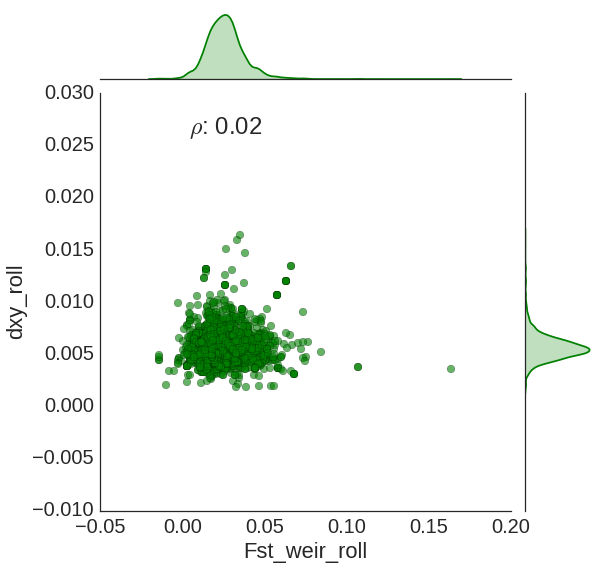

In [7]:
g = sns.JointGrid(x='Fst_weir_roll', 
                y='dxy_roll',
                data = rolling,
                size = 8)
g = g.plot_joint(plt.scatter, color="g", s=60, edgecolor="black", alpha = .6)
g = g.plot_marginals(sns.kdeplot, color="g", shade=True)
rho = lambda a, b: scipy.stats.spearmanr(a, b)[0] 
g = g.annotate(rho, template="{stat}: {val:.2f}", stat=r'$\rho$', loc="upper left", fontsize=24)

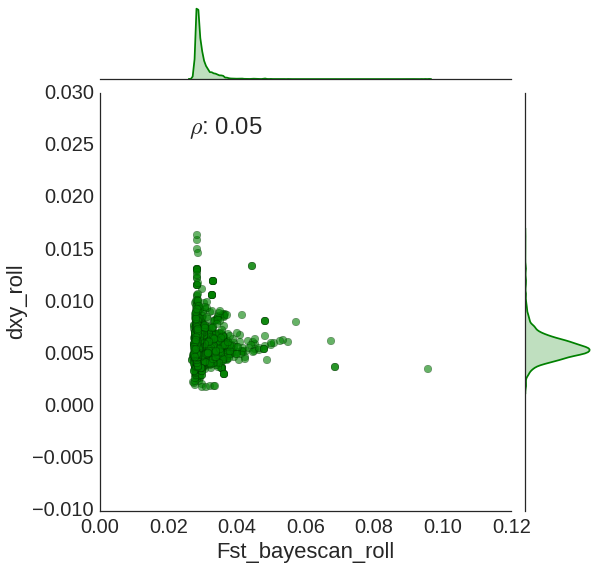

In [64]:
g = sns.JointGrid(x='Fst_bayescan_roll', 
                y='dxy_roll',
                data = rolling,
                size = 8)
g = g.plot_joint(plt.scatter, color="g", s=60, edgecolor="black", alpha = .6)
g = g.plot_marginals(sns.kdeplot, color="g", shade=True)
rho = lambda a, b: scipy.stats.spearmanr(a, b)[0] 
g = g.annotate(rho, template="{stat}: {val:.2f}", stat=r'$\rho$', loc="upper left", fontsize=24)

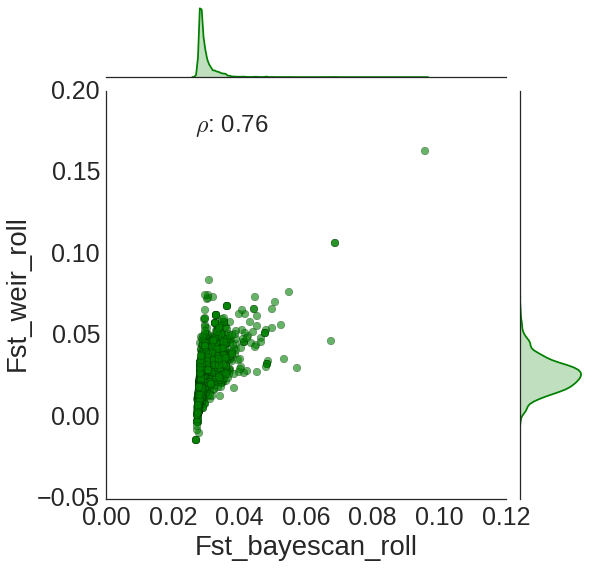

In [71]:
g = sns.JointGrid(x='Fst_bayescan_roll', 
                y='Fst_weir_roll',
                data = rolling,
                size = 8)
g = g.plot_joint(plt.scatter, color="g", s=60, edgecolor="black", alpha = .6)
g = g.plot_marginals(sns.kdeplot, color="g", shade=True)
rho = lambda a, b: scipy.stats.spearmanr(a, b)[0] 
g = g.annotate(rho, template="{stat}: {val:.2f}", stat=r'$\rho$', loc="upper left", fontsize=24)

# Manhattan plot(s)
could color individual outliers

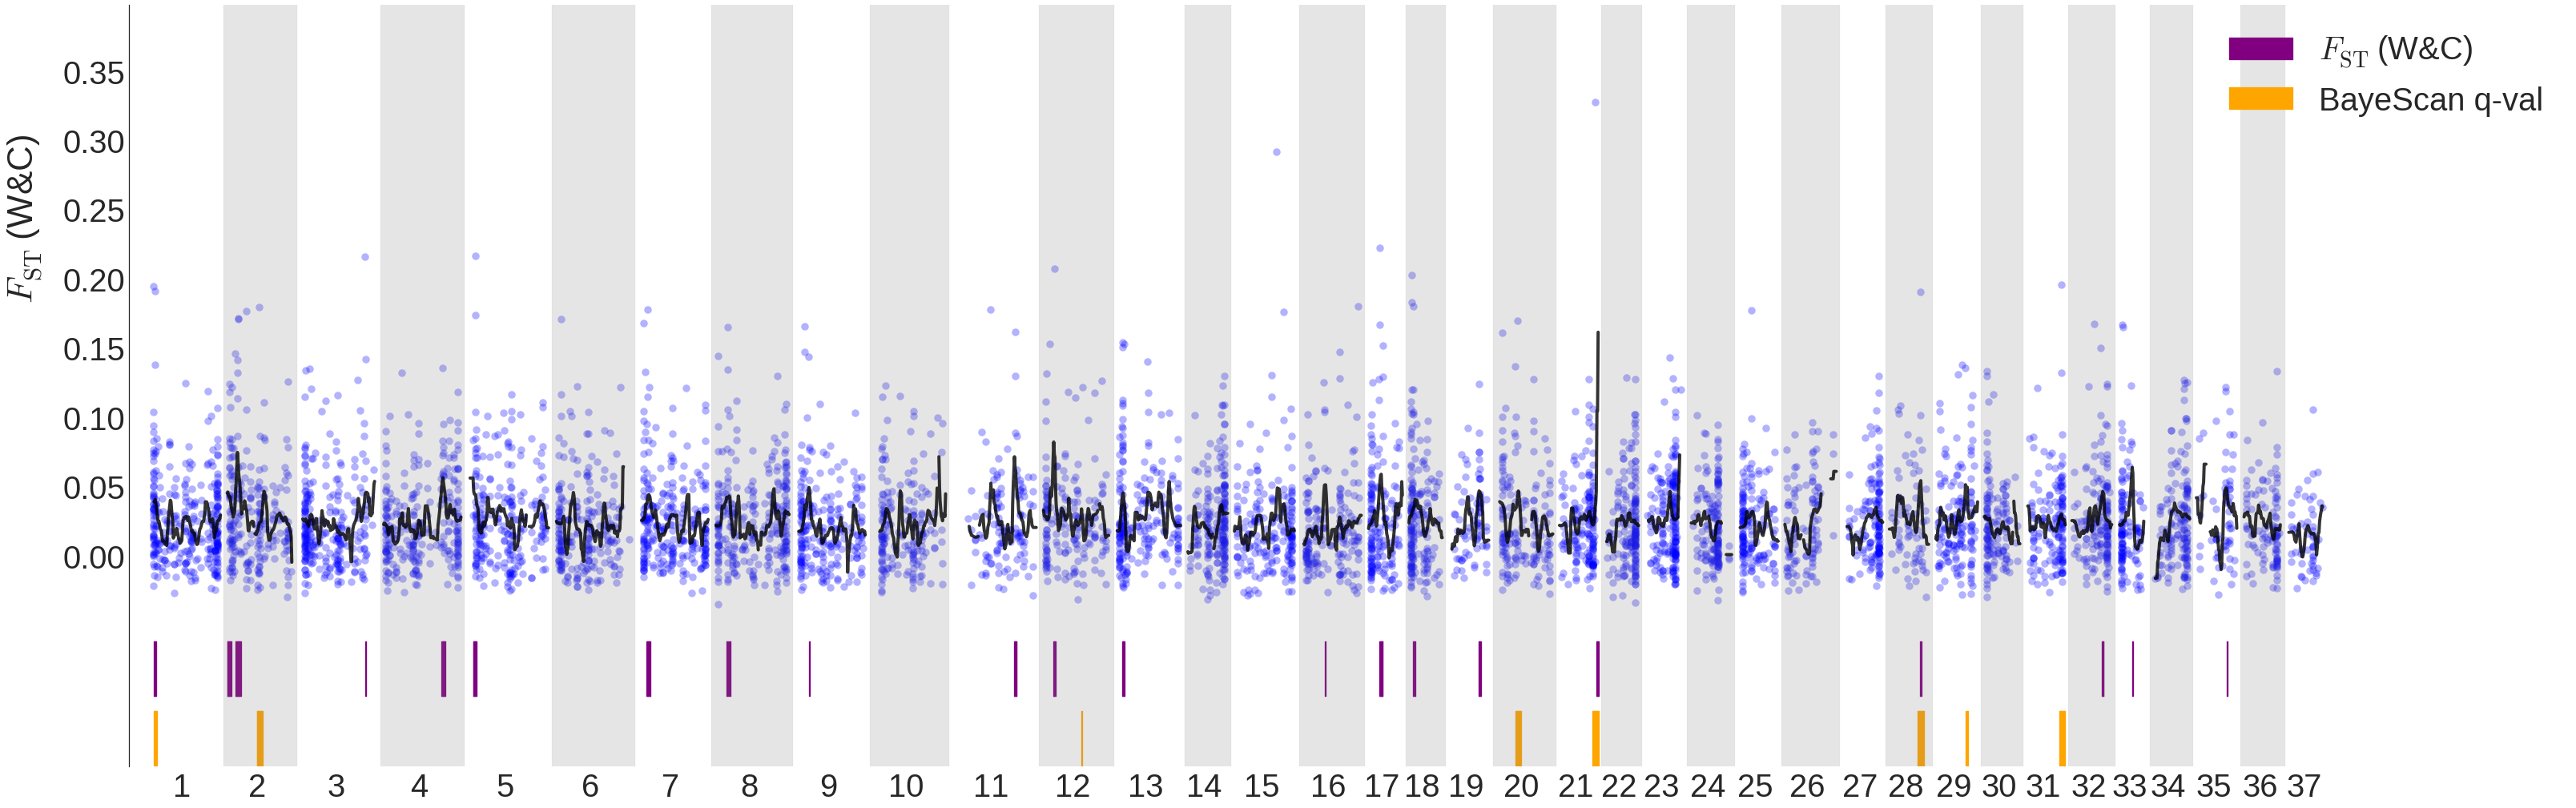

In [113]:
from matplotlib import rc
rc('text', usetex=False)

#figsize(10, 80)
sns.set(font_scale=4, style = "white")
stat = 'Fst_weir'

g = sns.lmplot(data = genome_stats, x = 'cM_padded', y = stat,  fit_reg=False, sharex=False,
           legend= False, size = 15, aspect = 3, truncate = True, scatter_kws={'s':90, 'alpha':.3, 'color':'blue'}, 
               #palette=sns.xkcd_palette(['red']), 
              #hue = 'paper1_LG',
              )
g.set(xlim=-40, ylim = -.15)
g.set(xticks=cumpos['cM_pad'][:37]-15 + np.diff(cumpos['cM_pad'])/2, xticklabels = np.arange(1, 38))
g.set(yticks=np.arange(0, .4, .05))
g.set_axis_labels('', stat)
sns.despine(left=False, bottom = True)

# add rolling mean of stat
plt.plot(cMs, rolling[stat+'_roll'], color = 'black', lw = 4, alpha =.8)
       
# significant differnatiation regions identified by bootstrap
for idx, vals in rolling.iterrows():
    if vals['Fst_weir_roll'] >= vals['Fst_weir_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.1),  2, .04, alpha = 1, color = 'purple', label = r'$F_{\mathrm{ST}}$ (W&C)'))

for idx, vals in rolling.iterrows():
    if vals['mlog10(qval)_bayescan_roll'] >= vals['mlog10(qval)_bayescan_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.15),  2, .04, alpha = 1, color = 'orange', label = r'BayeScan q-val'))      
#for idx, vals in rolling.iterrows():
#    if vals['mlog10(fdr_pval)_LFMM_roll'] >= vals['mlog10(fdr_pval)_LFMM_bootstrap95']:
#        currentAxis = plt.gca()
#        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.2),  2, .04, alpha = 1, color = 'purple', label = r'LFMM p-val'))        
        
        
# shade behind alternate LGs        
currentLG = 1
for idx, LG_box_left in enumerate(genome_stats.groupby('LG')['cM_pad'].mean().values[:36]):
    box_width = np.diff(genome_stats.groupby('LG')['cM_pad'].mean().values)[idx]
    if currentLG%2 == 0:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((LG_box_left-10, -5),  box_width, 10, alpha = .2, color = 'gray'))
    currentLG+=1

from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.gca().set_ylabel(r'$F_{\mathrm{ST}}$ (W&C)')
plt.gca().yaxis.set_label_coords(-0.035, 0.72)
#sns.despine(left = True, bottom = True)

    
#sns.despine(right = False)
plt.savefig(os.path.join('paper', 'figures', 'weir_Fst_and_bootstrap.defense.png'), bbox_inches = 'tight')
plt.show()

# Just LG 2

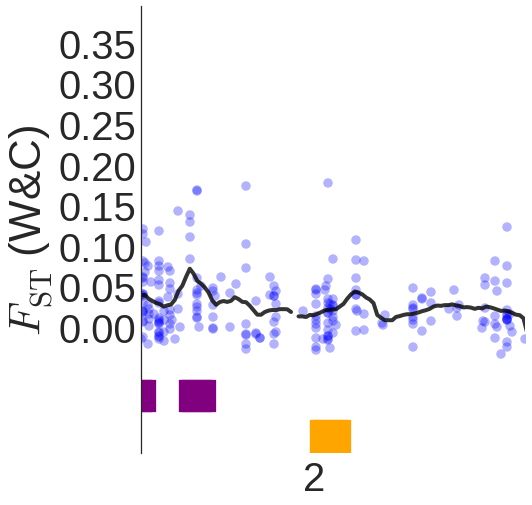

In [48]:
from matplotlib import rc
rc('text', usetex=False)

#figsize(10, 80)
sns.set(font_scale=4, style = "white")
stat = 'Fst_weir'

g = sns.lmplot(data = genome_stats, x = 'cM_padded', y = stat,  fit_reg=False, sharex=False,
           legend= False, size = 8, aspect = 1, truncate = True, scatter_kws={'s':90, 'alpha':.3, 'color':'blue'}, 
               #palette=sns.xkcd_palette(['red']), 
              #hue = 'paper1_LG',
              )
g.set(xlim=-40, ylim = -.15)
g.set(xticks=cumpos['cM_pad'][:37]-15 + np.diff(cumpos['cM_pad'])/2, xticklabels = np.arange(1, 38))
g.set(yticks=np.arange(0, .4, .05))
g.set_axis_labels('', stat)
sns.despine(left=False, bottom = True)

# add rolling mean of stat
plt.plot(cMs, rolling[stat+'_roll'], color = 'black', lw = 4, alpha =.8)
       
# significant differnatiation regions identified by bootstrap
for idx, vals in rolling.iterrows():
    if vals['Fst_weir_roll'] >= vals['Fst_weir_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.1),  2, .04, alpha = 1, color = 'purple', label = r'$F_{\mathrm{ST}}$ (W&C)'))

for idx, vals in rolling.iterrows():
    if vals['mlog10(qval)_bayescan_roll'] >= vals['mlog10(qval)_bayescan_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.15),  2, .04, alpha = 1, color = 'orange', label = r'BayeScan q-val'))      
#for idx, vals in rolling.iterrows():
#    if vals['mlog10(fdr_pval)_LFMM_roll'] >= vals['mlog10(fdr_pval)_LFMM_bootstrap95']:
#        currentAxis = plt.gca()
#        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.2),  2, .04, alpha = 1, color = 'purple', label = r'LFMM p-val'))        
        
        
# shade behind alternate LGs        


#from collections import OrderedDict
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = OrderedDict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())

plt.gca().set_ylabel(r'$F_{\mathrm{ST}}$ (W&C)')
#plt.gca().yaxis.set_label_coords(-0.035, 0.72)
#sns.despine(left = True, bottom = True)

g.set(xlim = [genome_stats[genome_stats['LG'] ==2]['cM_padded'].min(), genome_stats[genome_stats['LG'] ==2]['cM_padded'].max()])    
#sns.despine(right = False)
plt.savefig(os.path.join('paper', 'figures', 'weir_Fst_and_bootstrap.defense.LG2.png'), bbox_inches = 'tight')
plt.show()

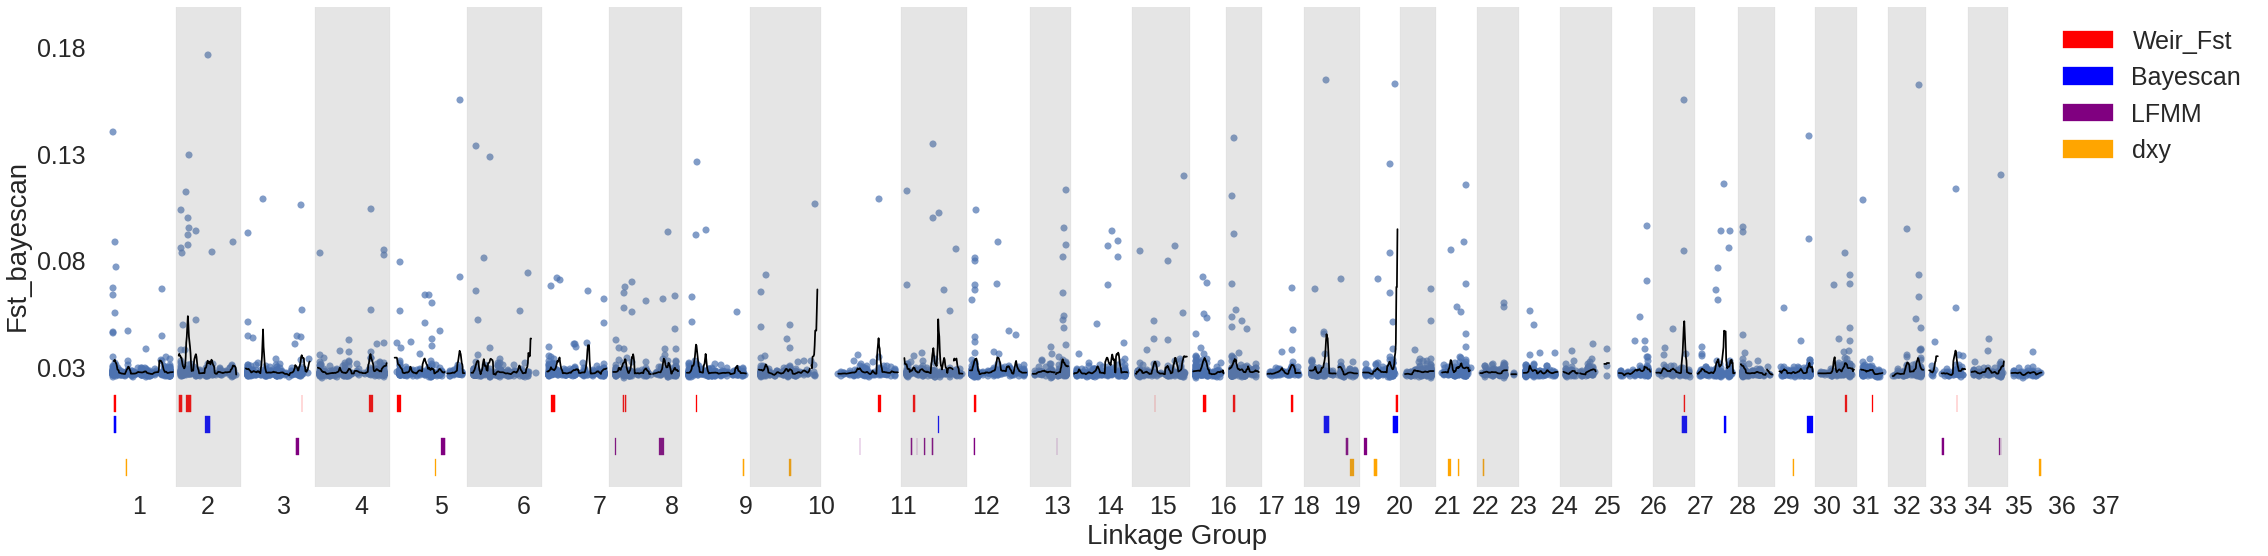

In [56]:
sns.set(font_scale=2.5, style = "white")
stat = 'Fst_bayescan'
g = sns.lmplot(data = genome_stats, x = 'cM_padded', y = stat,  fit_reg=False, sharex=False,
           legend= False, size = 8, aspect = 4, truncate = True, scatter_kws={'s':50, 'alpha':.7}, palette="Set2", 
              #hue = 'paper1_LG',
              )
g.set(xlim=-40, ylim = -.025)
g.set(xticks=cumpos['cM_pad'][:37]-15 + np.diff(cumpos['cM_pad'])/2, xticklabels = np.arange(1, 38))
g.set(yticks=np.arange(0.03, .2, .05))
g.set_axis_labels('Linkage Group', stat)
sns.despine(left=False, bottom = True)

# add rolling mean of stat
plt.plot(cMs, rolling[stat+'_roll'], color = 'black')


        
# significant differnatiation regions identified by bootstrap
for idx, vals in rolling.iterrows():
    if vals['Fst_weir_roll'] >= vals['Fst_weir_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], 0.01),  1, .008, alpha = 1, color = 'red', label = 'Weir_Fst'))

for idx, vals in rolling.iterrows():
    if vals['mlog10(qval)_bayescan_roll'] >= vals['mlog10(qval)_bayescan_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.00),  1, .008, alpha = 1, color = 'blue', label = 'Bayescan'))
        
#for idx, vals in rolling.iterrows():
#    if vals['Fst_bayescan_roll'] >= vals['Fst_bayescan_bootstrap95']:
#        currentAxis = plt.gca()
#        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.02),  1, .008, alpha = 1, color = 'green', label = 'Bayescan_Fst'))       

for idx, vals in rolling.iterrows():
    if vals['mlog10(fdr_pval)_LFMM_roll'] >= vals['mlog10(fdr_pval)_LFMM_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.01),  1, .008, alpha = 1, color = 'purple', label = 'LFMM'))        

for idx, vals in rolling.iterrows():
    if vals['dxy_roll'] >= vals['dxy_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.02),  1, .008, alpha = 1, color = 'orange', label = 'dxy'))  
        
# shade behind alternate LGs        
currentLG = 1
for idx, LG_box_left in enumerate(genome_stats.groupby('LG')['cM_pad'].mean().values[:36]):
    box_width = np.diff(genome_stats.groupby('LG')['cM_pad'].mean().values)[idx]
    if currentLG%2 == 0:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((LG_box_left-10, -5),  box_width, 10, alpha = .2, color = 'gray'))
    currentLG+=1

from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

sns.despine(left = True, bottom = True)

#plt.savefig(os.path.join('paper', 'figures', 'Bayescan_Fst_and_bootstrap.png'))
plt.show()

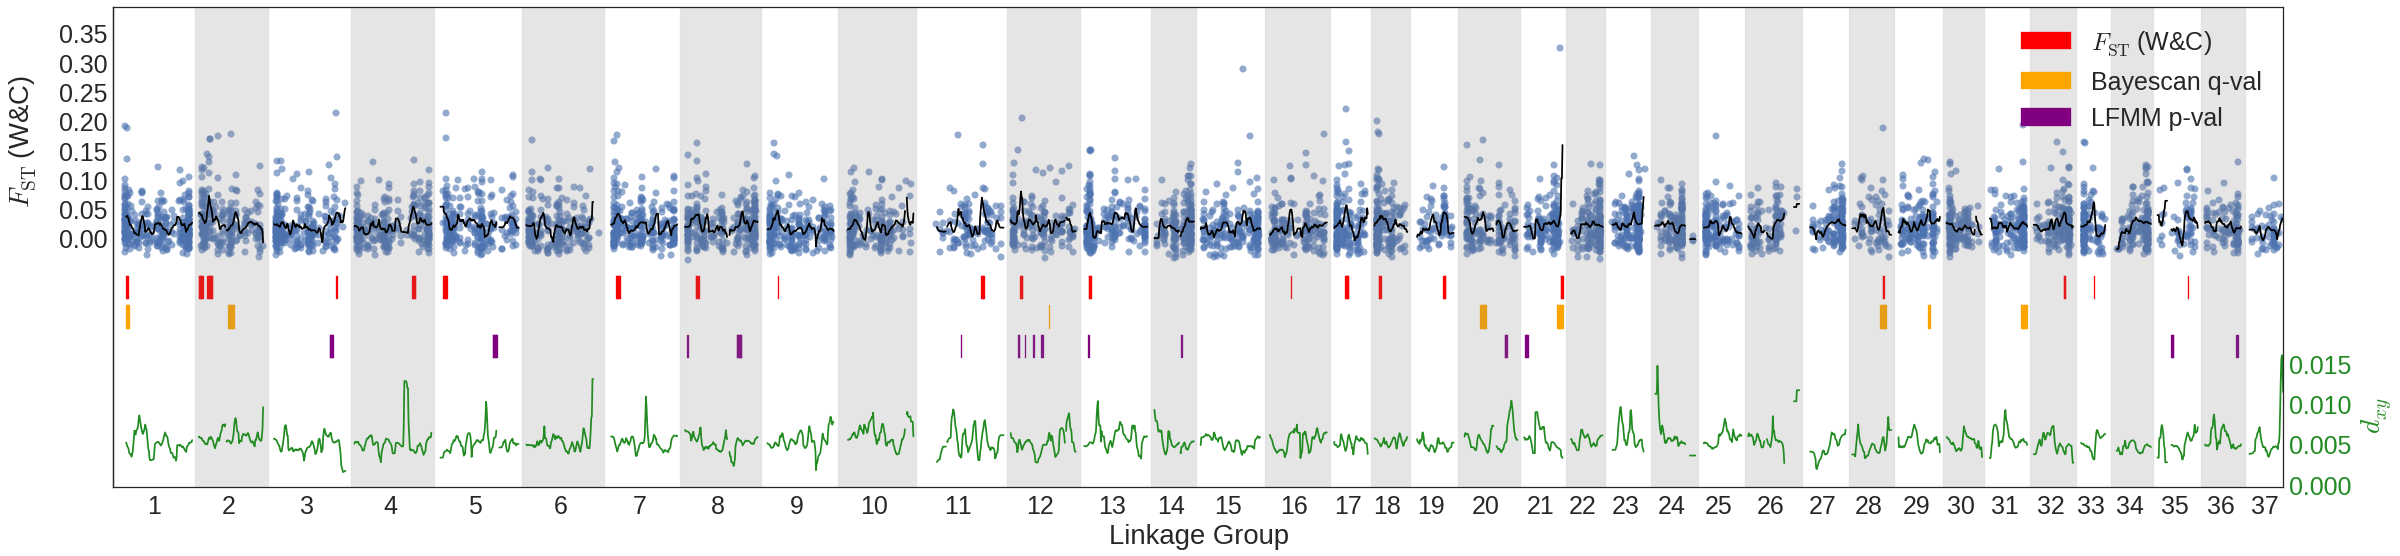

In [46]:
from matplotlib import rc
rc('text', usetex=False)

#figsize(10, 80)
sns.set(font_scale=2.5, style = "white")
stat = 'Fst_weir'

g = sns.lmplot(data = genome_stats, x = 'cM_padded', y = stat,  fit_reg=False, sharex=False,
           legend= False, size = 8, aspect = 4, truncate = True, scatter_kws={'s':50, 'alpha':.6}, palette="Set2", 
              #hue = 'paper1_LG',
              )
g.set(xlim=-40, ylim = -.42)
g.set(xticks=cumpos['cM_pad'][:37]-15 + np.diff(cumpos['cM_pad'])/2, xticklabels = np.arange(1, 38))
g.set(yticks=np.arange(-0.00, .4, .05))
g.set_axis_labels('Linkage Group', stat)
sns.despine(left=False, bottom = True)

# add rolling mean of stat
plt.plot(cMs, rolling[stat+'_roll'], color = 'black')


       
# significant differnatiation regions identified by bootstrap
for idx, vals in rolling.iterrows():
    if vals['Fst_weir_roll'] >= vals['Fst_weir_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.1),  2, .04, alpha = 1, color = 'red', label = r'$F_{\mathrm{ST}}$ (W&C)'))

for idx, vals in rolling.iterrows():
    if vals['mlog10(qval)_bayescan_roll'] >= vals['mlog10(qval)_bayescan_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.15),  2, .04, alpha = 1, color = 'orange', label = r'Bayescan q-val'))      
for idx, vals in rolling.iterrows():
    if vals['mlog10(fdr_pval)_LFMM_roll'] >= vals['mlog10(fdr_pval)_LFMM_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.2),  2, .04, alpha = 1, color = 'purple', label = r'LFMM p-val'))        
        
#for idx, vals in rolling.iterrows():
#    if vals['Fst_bayescan_roll'] >= vals['Fst_bayescan_bootstrap95']:
#        currentAxis = plt.gca()
#        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.02),  1, .008, alpha = 1, color = 'green', label = 'Bayescan_Fst'))   

#for idx, vals in rolling.iterrows():
#    if vals['dxy_roll'] >= vals['dxy_bootstrap95']:
#        currentAxis = plt.gca()
#        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.19),  1, .04, alpha = 1, color = 'orange', label = 'dxy'))  
        
# shade behind alternate LGs        
currentLG = 1
for idx, LG_box_left in enumerate(genome_stats.groupby('LG')['cM_pad'].mean().values[:36]):
    box_width = np.diff(genome_stats.groupby('LG')['cM_pad'].mean().values)[idx]
    if currentLG%2 == 0:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((LG_box_left-10, -5),  box_width, 10, alpha = .2, color = 'gray'))
    currentLG+=1

from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.gca().set_ylabel(r'$F_{\mathrm{ST}}$ (W&C)')
plt.gca().yaxis.set_label_coords(-0.035, 0.72)
#sns.despine(left = True, bottom = True)

ax2 = plt.gca().twinx()
ax2.plot(cMs, rolling['dxy_roll'], color = '#228B22')
ax2.set_ylim((.001, .06))
ax2.set_yticks(np.arange(0, .02, .005))
ax2.set_xlim((-20))
ax2.set_ylabel(r'$d_{xy}$', color = '#228B22')
ax2.yaxis.set_label_coords(1.035, 0.15)

for tl in ax2.get_yticklabels():
    tl.set_color('#228B22')
    
    
#sns.despine(right = False)
plt.savefig(os.path.join('paper', 'figures', 'weir_Fst_and_bootstrap.png'), bbox_inches = 'tight')
plt.show()

## dxy

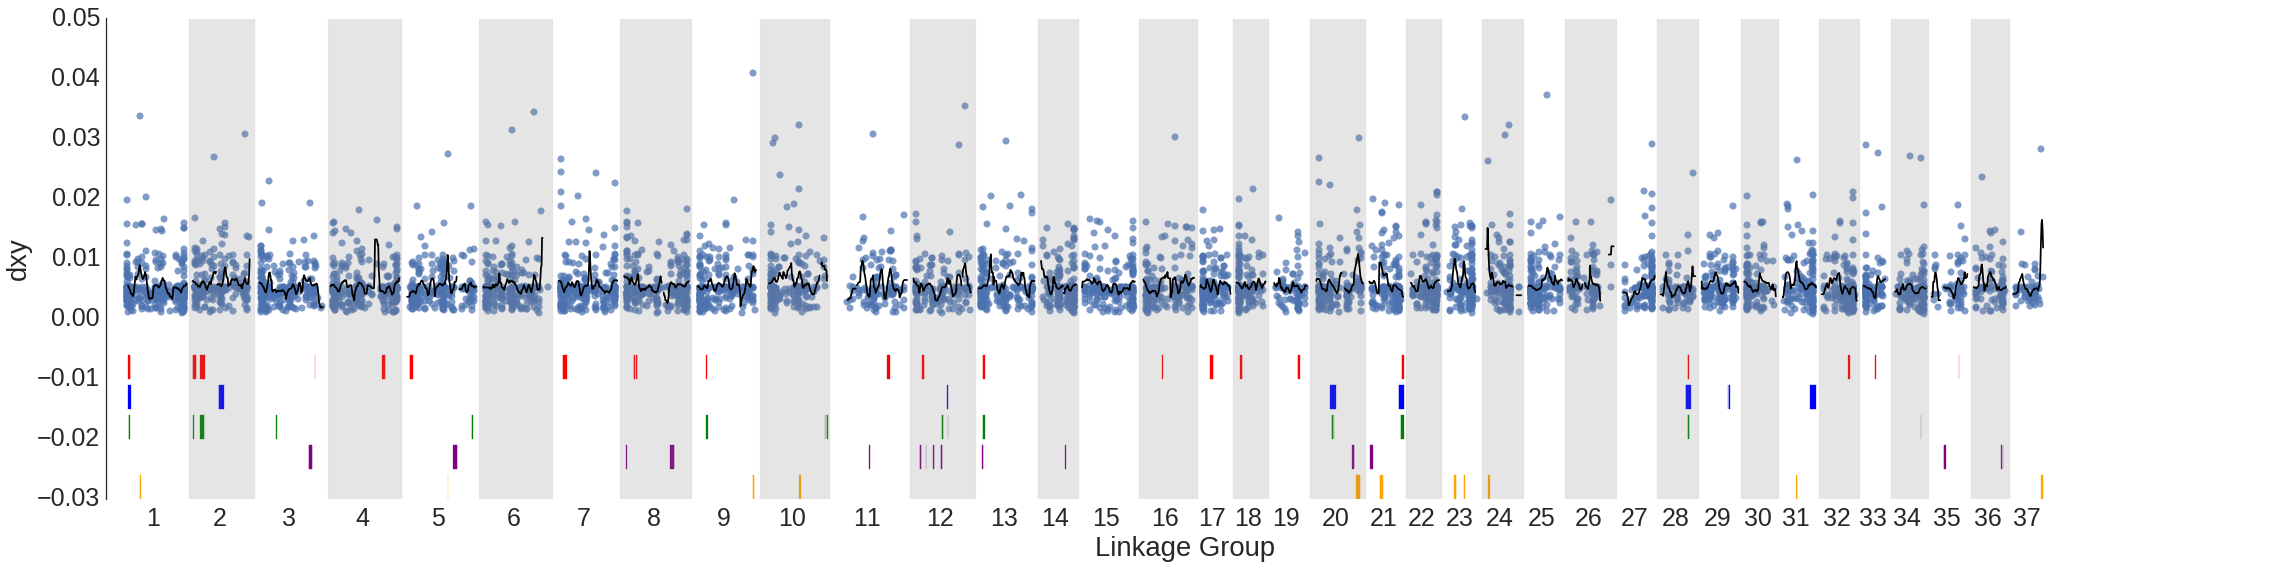

In [66]:
sns.set(font_scale=2.5, style = "white")
stat = 'dxy'
g = sns.lmplot(data = genome_stats, x = 'cM_padded', y = stat,  fit_reg=False, sharex=False,
           legend= False, size = 8, aspect = 4, truncate = True, scatter_kws={'s':50, 'alpha':.7}, palette="Set2", 
              #hue = 'paper1_LG',
              )
g.set(xlim=-40, ylim = -.03)
g.set(xticks=cumpos['cM_pad'][:37]-15 + np.diff(cumpos['cM_pad'])/2, xticklabels = np.arange(1, 38))
g.set_axis_labels('Linkage Group', stat)
sns.despine(left=False, bottom = True)

# add rolling mean of stat
plt.plot(cMs, rolling[stat+'_roll'], color = 'black')


        
# significant differnatiation regions identified by bootstrap
for idx, vals in rolling.iterrows():
    if vals['Fst_weir_roll'] >= vals['Fst_weir_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.01),  1, .004, alpha = 1, color = 'red', label = 'Weir_Fst'))

for idx, vals in rolling.iterrows():
    if vals['mlog10(qval)_bayescan_roll'] >= vals['mlog10(qval)_bayescan_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.015),  1, .004, alpha = 1, color = 'blue', label = 'Bayescan'))
        
for idx, vals in rolling.iterrows():
    if vals['Fst_bayescan_roll'] >= vals['Fst_bayescan_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.02),  1, .004, alpha = 1, color = 'green', label = 'Bayescan_Fst'))       

for idx, vals in rolling.iterrows():
    if vals['mlog10(fdr_pval)_LFMM_roll'] >= vals['mlog10(fdr_pval)_LFMM_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.025),  1, .004, alpha = 1, color = 'purple', label = 'mlog10(fdr_pval)_LFMM'))        

for idx, vals in rolling.iterrows():
    if vals['dxy_roll'] >= vals['dxy_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.03),  1, .004, alpha = 1, color = 'orange', label = 'dxy'))           
        
currentLG = 1
for idx, LG_box_left in enumerate(genome_stats.groupby('LG')['cM_pad'].mean().values[:36]):
    box_width = np.diff(genome_stats.groupby('LG')['cM_pad'].mean().values)[idx]
    if currentLG%2 == 0:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((LG_box_left-10, -5),  box_width, 10, alpha = .2, color = 'gray'))
    currentLG+=1

plt.savefig(os.path.join('paper', 'figures', 'dxy_and_bootstrap.png'))
plt.show()

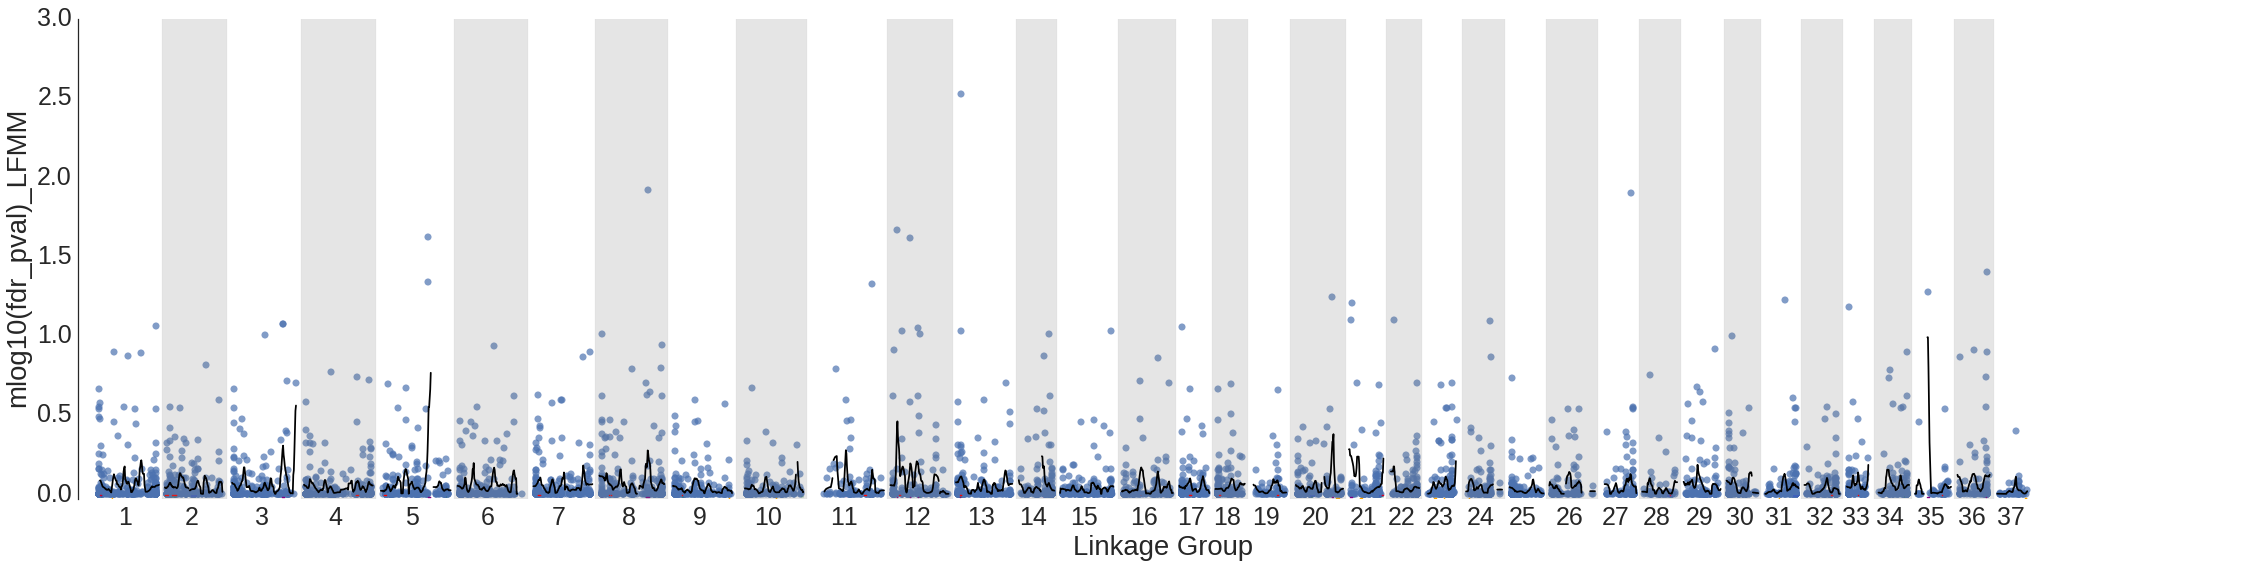

In [67]:
sns.set(font_scale=2.5, style = "white")
stat = 'mlog10(fdr_pval)_LFMM'
g = sns.lmplot(data = genome_stats, x = 'cM_padded', y = stat,  fit_reg=False, sharex=False,
           legend= False, size = 8, aspect = 4, truncate = True, scatter_kws={'s':50, 'alpha':.7}, palette="Set2", 
              #hue = 'paper1_LG',
              )
g.set(xlim=-40, ylim = -.03)
g.set(xticks=cumpos['cM_pad'][:37]-15 + np.diff(cumpos['cM_pad'])/2, xticklabels = np.arange(1, 38))
g.set_axis_labels('Linkage Group', stat)
sns.despine(left=False, bottom = True)

# add rolling mean of stat
plt.plot(cMs, rolling[stat+'_roll'], color = 'black')


        
# significant differnatiation regions identified by bootstrap
for idx, vals in rolling.iterrows():
    if vals['Fst_weir_roll'] >= vals['Fst_weir_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.01),  1, .004, alpha = 1, color = 'red', label = 'Weir_Fst'))

for idx, vals in rolling.iterrows():
    if vals['mlog10(qval)_bayescan_roll'] >= vals['mlog10(qval)_bayescan_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.015),  1, .004, alpha = 1, color = 'blue', label = 'Bayescan'))
        
for idx, vals in rolling.iterrows():
    if vals['Fst_bayescan_roll'] >= vals['Fst_bayescan_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.02),  1, .004, alpha = 1, color = 'green', label = 'Bayescan_Fst'))       

for idx, vals in rolling.iterrows():
    if vals['mlog10(fdr_pval)_LFMM_roll'] >= vals['mlog10(fdr_pval)_LFMM_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.025),  1, .004, alpha = 1, color = 'purple', label = 'mlog10(fdr_pval)_LFMM'))        

for idx, vals in rolling.iterrows():
    if vals['dxy_roll'] >= vals['dxy_bootstrap95']:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((vals['pos'], -0.03),  1, .004, alpha = 1, color = 'orange', label = 'dxy'))           
        
currentLG = 1
for idx, LG_box_left in enumerate(genome_stats.groupby('LG')['cM_pad'].mean().values[:36]):
    box_width = np.diff(genome_stats.groupby('LG')['cM_pad'].mean().values)[idx]
    if currentLG%2 == 0:
        currentAxis = plt.gca()
        currentAxis.add_patch(matplotlib.patches.Rectangle((LG_box_left-10, -5),  box_width, 10, alpha = .2, color = 'gray'))
    currentLG+=1

plt.savefig(os.path.join('paper', 'figures', 'LFMM_and_bootstrap.png'))
plt.show()

In [ ]:
assert False

# Stats and moving averages

In [ ]:
genome_stats.head()

In [ ]:
stats = ['Fst_weir', 'Fst_bayescan',  'mlog10(qval)_bayescan', 'alpha_bayescan', 'zscore', 'mlog10(fdr_pval)_LFMM']

In [ ]:
sns.set(font_scale=2.5, style = "white")
for stat in stats:
    g = sns.lmplot(data = genome_stats, x = 'cM_padded', y = stat,  fit_reg=False, sharex=False,
               legend= False, size = 8, aspect = 4, truncate = True, scatter_kws={'s':50, 'alpha':.7}, palette="Set2" 
                  )
    g.set(xlim=-40)
    #g.set(xticks=cumpos['cM_pad']+30, xticklabels = np.arange(1, 38))
    
    g.set(xticks=cumpos['cM_pad'][:37]-15 + np.diff(cumpos['cM_pad'])/2, xticklabels = np.arange(1, 38))
    g.set_axis_labels('Linkage Group', stat)
    sns.despine(left=False, bottom = True)

    # add rolling mean of stat
    plt.plot(cMs, rolling[stat+'_roll'], color = 'black')
    
    # add shading showing LGs
    currentLG = 1
    for idx, LG_box_left in enumerate(genome_stats.groupby('LG')['cM_pad'].mean().values[:36]):
        box_width = np.diff(genome_stats.groupby('LG')['cM_pad'].mean().values)[idx]
        if currentLG%2 == 0:
            currentAxis = plt.gca()
            currentAxis.add_patch(matplotlib.patches.Rectangle((LG_box_left-10, -5),  box_width, 10, alpha = .2, color = 'yellow'))
        currentLG+=1
    plt.savefig(os.path.join('paper', 'figures', 'supplemental', stat + '.genome_scan.png'))
    plt.show()

In [ ]:
assert False

## Plot of LEPMAP map

In [ ]:
figsize(16, 6)

plt.scatter(x = mapped_loci.paper1_LG, y = mapped_loci['cM'], alpha = .5, s = 30, c = 'blue')
plt.xlim(0, 38); 
plt.ylim(-5); 
plt.xlabel('LG',fontsize = 24); plt.ylabel("cM",fontsize = 24)
plt.xticks(range(1, max(mapped_loci.LEP_LG)+1), fontsize = 16)
plt.show()

## WORKING HERE

In [ ]:
pop_loci = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/on_map.map', 
            sep = '\t', header = None)
pop_loci.columns = ['LEP_LG', 'stacks_SNP', 'junk', 'pos']
pop_loci = pop_loci[['stacks_SNP']]
print(len(pop_loci))
pop_loci.head()

In [ ]:
all_mapped_snps = pd.merge(pop_loci, mapped_loci, on = 'stacks_SNP')

#### notice this is a *.map file produced by the 'populations' program from Stacks, not LEPmap

In [ ]:
non_paralogs_snpfile = "/home/ipseg/Desktop/waples/chum_populations/results/batch_4/pop_analysis/non_paralogs.map"
non_paralog_loci = pd.read_csv(non_paralogs_snpfile, sep ="\t", header = None, comment = "#")
non_paralog_loci.columns = ['contig', 'stacks_SNP', 'ignore', 'pos']
non_paralog_loci = non_paralog_loci[['stacks_SNP']]
non_paralog_loci.head()

In [ ]:
mapped_non_paralogs = pd.merge(non_paralog_loci, mapped_loci, on = 'stacks_SNP')
mapped_non_paralogs.head(5)

### plot mapped SNPs that we observe in the population data

In [ ]:
plt.scatter(x = mapped_non_paralogs.paper1_LG, y = mapped_non_paralogs.cM, alpha = .3, s = 30, c = 'blue')
plt.xlim(0, 38); 
plt.ylim(-5); 
plt.xlabel('LG',fontsize = 24); plt.ylabel("cM",fontsize = 24)
plt.xticks(range(1, max(mapped_non_paralogs.paper1_LG)+1), fontsize = 16)
plt.show()

### First look at Fst across the genome

In [ ]:
pop_fst = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/non_paralogs.fst', sep= '\t')
pop_fst.rename(columns = {'SNP':'stacks_SNP'}, inplace=True)
pop_fst.head()

In [ ]:
map_pop_fst = pd.merge(mapped_non_paralogs, pop_fst, on = 'stacks_SNP')

In [ ]:
bayescan_results = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/pop_analysis/mapped_bayescan.txt', sep = "\t")
bayescan_results.head()

In [ ]:
map_fst = pd.merge(map_pop_fst, bayescan_results, on = 'stacks_SNP')
map_fst.shape

In [ ]:
map_fst.rename(columns = {'FST':'WC_Fst', 'fst':'BS_Fst'}, inplace = True)
map_fst.to_csv('/home/ipseg/Desktop/waples/chum_populations/results/batch_4/pop_analysis/map_fst.txt', sep = "\t", index = False)
map_fst.head()

In [ ]:
sns.set(font_scale=2)
figsize(16, 120)

fig, axarr = plt.subplots(nrows = 37, sharey=True, sharex=True)
for idx, LG in enumerate(set(map_pop_fst.paper1_LG)):
    LG_data = map_pop_fst[map_pop_fst.paper1_LG == LG]
    axarr[idx].scatter(x=LG_data.cM, y=LG_data.FST , alpha = .2, s = 60)
    axarr[idx].axhline(c= 'grey',ls = '--')
    axarr[idx].set_title(LG)

plt.xlim(-1, max(map_pop_fst.cM)+1)
plt.tight_layout()
plt.show()    

In [ ]:
### similar in seaborn

In [ ]:
%matplotlib inline
# lowess fits are too broad
g = sns.FacetGrid(map_pop_fst, row="LEP_LG", size=5, aspect = 3)
g.map(sns.regplot, 'cM', 'FST', ci = 95, scatter = True, lowess = True, truncate= True)
g.set(xlim=(0, max(map_pop_fst.cM)))

In [ ]:
%matplotlib inline
import statsmodels.api as sm
figsize(16, 120)
# some code adapted from:
#http://nbviewer.ipython.org/urls/gist.githubusercontent.com/TomAugspurger/6e052140eaa5fdb6e8c0/raw/811585624e843f3f80b9b6fe89e18119d7d2d73c/dplyr_pandas.ipynb

fig, axarr = plt.subplots(nrows = 37, sharey=True, sharex=True)
for idx, LG in enumerate(set(map_pop_fst.LEP_LG)):
    LG_data = map_pop_fst[map_pop_fst.LEP_LG == LG]
    smooth = sm.nonparametric.lowess( LG_data.FST, LG_data.cM, frac=.1)
    axarr[idx].plot(smooth[:, 0], smooth[:, 1], linewidth=3);
    std = smooth[:, 1].std()
    axarr[idx].fill_between(smooth[:, 0], smooth[:, 1] - std, smooth[:, 1] + std, alpha=.25);
    axarr[idx].scatter(x=LG_data.cM, y=LG_data.FST , alpha = .5, s = 60)
    axarr[idx].axhline(c= 'grey',ls = '--')
    axarr[idx].set_title(LG)

plt.xlim(-1, max(map_pop_fst.cM)+1)
plt.tight_layout()
plt.show()

In [ ]:
sm.nonparametric.lowess(map_pop_fst.FST, map_pop_fst.cM, =1)

## Look at overlap

In [ ]:
LEPmap_v_pop = pd.merge(pop_snps, mapnames, on = 'match', how = 'inner')
LEPmap_v_pop.head()

In [ ]:
LEPmap_v_pop_to_print = LEPmap_v_pop[['stacks_SNP', 'contig', 'LEP_LG']]

LEPmap_v_pop_to_print.to_csv('/home/ipseg/Desktop/waples/chum_populations/data/batch_4/lep_v_pop.txt', 
                                             sep = "\t", index = False)

In [ ]:
## Retained in populations after filtering

In [ ]:
retained_pop_snpfile = "/home/ipseg/Desktop/waples/chum_populations/data/batch_4/pop_genotypes/final.snplist"
retained_pop_snps = pd.read_csv(retained_pop_snpfile, sep = "\t", header = None)
retained_pop_snps.columns = ['stacks_SNP']
retained_pop_snps.head()

In [ ]:
retained = pd.merge(LEPmap_v_pop, retained_pop_snps)
print(retained.shape)
retained.head()

In [ ]:
chum_08_map_filename = '/olympus/WORK/WAPLES/Stacks_mapping/Chum_data/consensus/chum_08_PSV_map_ALIGNED.tsv'
chum_08_map = pd.read_csv(chum_08_map_filename, sep = "\t", header = None)
chum_08_map.columns = ['LG', 'SNPx', 'cM']
chum_08_map['match'] = [xx[0] for xx in chum_08_map['SNPx'].str.split("_") ]

pd.merge(pop_snps, chum_08_map).head()

In [ ]:
aa = pd.merge(mapnames, chum_08_map, on =['match'])
aa = aa[aa['match'] != 'Oke']
bb = pd.merge(aa, pop_snps)
bb = bb.drop_duplicates(['lepname'])
bb.head()
bb.shape

In [ ]:
!pwd